## M2 - release: reductions

### 1. Setup

#### Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap

from sklearn.linear_model import LinearRegression

sns.set_theme()

#### Functions

In [2]:
class Feats():
    """
    Each feature has a first name, optionally a second name, a statistic and a number.
    This class allows to group feautures according to these aspects or combinations of these aspects.
    Each method produces a list of feature names or a list of lists of feature names.
    """

    def __init__(self, csv):
        self.fts = pd.read_csv(csv, dtype={'n':"string"})
        self.fts = self.fts.fillna('')

    def format(self, select):
        return select.apply(lambda x: '_'.join(x).replace('__', '_'), axis=1).tolist()

    def all(self):
        select = self.fts.copy()
        return self.format(select)

    def first(self):
        select = self.fts.copy()
        select = select.loc[select['n']=='01']
        return self.format(select)

    def mean(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='mean']
        return self.format(select)
    
    def std(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='std']
        return self.format(select)

    def kurtosis(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='kurtosis']
        return self.format(select)
    
    def chroma(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='chroma']
        return self.format(select)

    def mfcc(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='mfcc']
        return self.format(select)

    def tonnetz(self):
        select = self.fts.copy()
        select = select.loc[select['name1']=='tonnetz']
        return self.format(select)

fts = Feats('features.csv')

#### Data
For this part of the analysis, we work on fold F3, and subsample 10,000 entries.

In [3]:
# Load fold f3
df_train = pd.read_csv('data/fold/f3_train.csv',  parse_dates=['release'])
df_train = df_train.drop(columns=['popularity'])
df_test = pd.read_csv('data/fold/f3_test.csv',  parse_dates=['release'])
df_test = df_test.drop(columns=['popularity'])
print(f'train set: {df_train.shape[0]:,} entries, test set: {df_test.shape[0]:,} entries, total: {df_train.shape[0]+df_test.shape[0]:,} entries')

# Subsample 10,0000 train for reduction analysis
df_red = df_train.sample(n=10000, random_state=1)
df_train, df_test = train_test_split(df_red, test_size=0.2, random_state=1)
print(f'reduction train set: {df_train.shape[0]:,} entries, reduction test set: {df_test.shape[0]:,} entries, reduction total: {df_train.shape[0]+df_test.shape[0]:,} entries')

train set: 68,207 entries, test set: 17,052 entries, total: 85,259 entries
reduction train set: 8,000 entries, reduction test set: 2,000 entries, reduction total: 10,000 entries


### 2. Preprocessing

In [4]:
# Drop NA values
n_orig = df_train.shape[0]
n_na = df_train['release'].isna().sum()
df_train = df_train.dropna(subset=['release'])
print(f'Train set: Dropped {n_na} NA entries of {n_orig}, {df_train.shape[0]} entries left.')
n_orig = df_test.shape[0]
n_na = df_test['release'].isna().sum()
df_test = df_test.dropna(subset=['release'])
print(f'Test set: Dropped {n_na} NA entries of {n_orig}, {df_test.shape[0]} entries left.')

Train set: Dropped 2727 NA entries of 8000, 5273 entries left.
Test set: Dropped 692 NA entries of 2000, 1308 entries left.


Train set: Dropped 43 <1990 entries of 5273, 5230 entries left.
Test set: Dropped 14 <1990 entries of 1308, 1294 entries left.


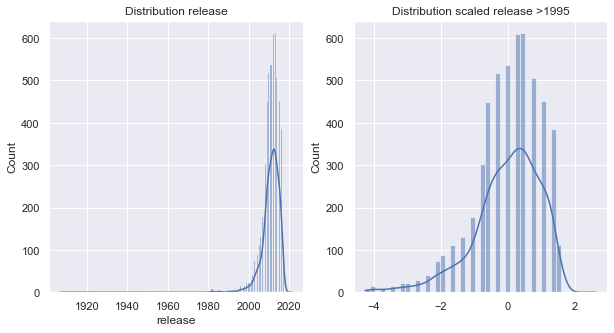

In [5]:
# Bin y per year
df_train['release'] = df_train['release'].dt.year.astype(int)
df_test['release'] = df_test['release'].dt.year.astype(int)

# Throw out values <1980
y_train_before = df_train['release']
n_orig = df_train.shape[0]
n_under = df_train.loc[df_train['release']<1995].shape[0]
df_train = df_train.loc[df_train['release']>=1995]
y_train = df_train['release']
print(f'Train set: Dropped {n_under} <1990 entries of {n_orig}, {df_train.shape[0]} entries left.')
n_orig = df_test.shape[0]
n_under = df_test.loc[df_test['release']<1995].shape[0]
df_test = df_test.loc[df_test['release']>=1995]
y_test = df_test['release']
print(f'Test set: Dropped {n_under} <1990 entries of {n_orig}, {df_test.shape[0]} entries left.')

# Scale y
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)
scaler = StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_train = pd.Series(y_train.reshape(1, -1)[0])
y_test = scaler.transform(y_test)
y_test = pd.Series(y_test.reshape(1, -1)[0])

fig, axs = plt.subplots(ncols=2, figsize=(10,5))
ax1 = sns.histplot(x=y_train_before, kde=True, ax=axs[0])
ax1.set(title="Distribution release")
ax2 = sns.histplot(x=y_train, kde=True, ax=axs[1])
ax2.set(title="Distribution scaled release >1995")
fig;

In [6]:
# Scale X
X_train = df_train.drop(columns=['release'])
X_test = df_test.drop(columns=['release'])
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=fts.all())
X_test = pd.DataFrame(X_test, columns=fts.all())
print('')
print(f'Scaled train X:\n\tmean: {X_train.mean().tolist()[:5]}...\n\tstd: {X_train.std().tolist()[:5]}...')
print(f'Scaled test X:\n\tmean: {X_test.mean().tolist()[:5]}...\n\tstd: {X_test.std().tolist()[:5]}...')


Scaled train X:
	mean: [-1.7661674120231935e-17, -5.094713688528443e-19, -1.4944493486350098e-17, 8.151541901645509e-18, -5.4343612677636725e-18]...
	std: [1.000095616006338, 1.000095616006338, 1.000095616006338, 1.000095616006338, 1.000095616006338]...
Scaled test X:
	mean: [0.027467169156637515, 0.01167232351573197, -0.010363213752973114, 0.02360076210351788, -0.013208887148618767]...
	std: [1.1147928653884036, 0.9834722460564457, 0.40071535303444816, 1.2208170280710677, 0.7775700693513051]...


### 3. Dimensionality reduction

#### Benchmark

In [7]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_train_bm = round(model.score(X_train, y_train), 6)
r2_test_bm = round(metrics.r2_score(y_test, y_pred), 6)

print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')

Benchmark: Train R2 for all features: 0.189326, Test R2 for all features: -0.021904


#### Grid

In [8]:
fts_sets = {'all':fts.all(), 'first':fts.first(), 'mean':fts.mean(), 'std':fts.std(), 'kurtosis':fts.kurtosis(), 'chroma':fts.chroma(), 'mfcc':fts.mfcc(), 'tonnetz':fts.tonnetz()}
n_components = {'2':2, '10':10, '25':25, '45':45, '70':70, '100':100, '200':250, '300':250, '400':400, '500':518}

#### RFE - random feature elimination
[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [9]:
scores = {}
for fts_name, fts_set in fts_sets.items():
    scores[fts_name] = {}
    for n_name, n in n_components.items():
        X_train_fts = X_train[fts_set]
        X_test_fts = X_test[fts_set]
        if n > X_train_fts.shape[1]:
            scores[fts_name][n_name]= np.nan
        else:
            estimator = LinearRegression()
            red = RFE(estimator, n_features_to_select=n, step=5).fit(X_train_fts, y_train)
            X_train_components = red.transform(X_train_fts)
            X_test_components = red.transform(X_test_fts)
            model = LinearRegression().fit(X_train_components, y_train)
            y_pred = model.predict(X_test_components)
            r2 = round(metrics.r2_score(y_test, y_pred), 6)
            scores[fts_name][n_name]= r2

In [10]:
# Keeping all features and no dim reduction results in the highest R2
print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')
print(f'--------------------------------------------------')
print(f'Test R2 for featset, n_components')
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='lightgreen', axis=1)\
    .highlight_max(color='green', axis=None)\
    .highlight_min(color='tomato', axis=1)\
    .highlight_min(color='red', axis=None)

Benchmark: Train R2 for all features: 0.189326, Test R2 for all features: -0.021904
--------------------------------------------------
Test R2 for featset, n_components


,2,10,25,45,70,100,200,300,400,500
all,-0.006563,-0.008280,-0.012664,0.006582,0.006096,0.004758,-0.005412,-0.005412,-0.017794,-0.021904
first,-0.006563,0.010986,0.018537,0.023844,0.025349,nan,nan,nan,nan,nan
mean,0.007683,0.012910,-0.004357,0.003739,0.003120,nan,nan,nan,nan,nan
std,0.008886,-0.000711,0.000637,-0.009156,-0.005463,nan,nan,nan,nan,nan
kurtosis,0.008097,0.002169,-0.002672,0.000198,-0.000153,nan,nan,nan,nan,nan
chroma,-0.002869,0.005142,-0.007139,-0.016688,-0.031082,-0.050898,-0.074625,-0.074625,nan,nan
mfcc,-0.001330,0.000705,0.004329,0.023407,0.019044,0.024317,nan,nan,nan,nan
tonnetz,0.007768,0.008069,0.004952,nan,nan,nan,nan,nan,nan,nan


#### PCA - principal component analysis
[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA)

In [11]:
scores = {}
for fts_name, fts_set in fts_sets.items():
    scores[fts_name] = {}
    for n_name, n in n_components.items():
        X_train_fts = X_train[fts_set]
        X_test_fts = X_test[fts_set]
        if n > X_train_fts.shape[1]:
            scores[fts_name][n_name]= np.nan
        else:
            red = PCA(n_components=n).fit(X_train_fts)
            X_train_components = red.transform(X_train_fts)
            X_test_components = red.transform(X_test_fts)
            model = LinearRegression().fit(X_train_components, y_train)
            y_pred = model.predict(X_test_components)
            r2 = round(metrics.r2_score(y_test, y_pred), 6)
            scores[fts_name][n_name]= r2

In [12]:
print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')
print(f'--------------------------------------------------')
print(f'Test R2 for featset, n_components')
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='lightgreen', axis=1)\
    .highlight_max(color='green', axis=None)\
    .highlight_min(color='tomato', axis=1)\
    .highlight_min(color='red', axis=None)

Benchmark: Train R2 for all features: 0.189326, Test R2 for all features: -0.021904
--------------------------------------------------
Test R2 for featset, n_components


,2,10,25,45,70,100,200,300,400,500
all,0.000565,0.006188,0.015298,0.031233,0.031812,0.024081,0.017170,0.019296,-0.008497,-0.021904
first,0.000341,0.024360,0.025993,0.023199,0.027819,nan,nan,nan,nan,nan
mean,-0.001115,0.003991,0.019910,0.016578,0.003168,nan,nan,nan,nan,nan
std,-0.005871,0.003201,0.002017,0.004808,-0.005635,nan,nan,nan,nan,nan
kurtosis,0.004784,0.014953,0.011593,0.009851,-0.000628,nan,nan,nan,nan,nan
chroma,-0.000118,-0.006854,-0.003966,-0.012748,-0.015281,-0.022289,-0.066059,-0.066059,nan,nan
mfcc,-0.003691,0.005415,0.018907,0.015088,0.009835,0.017739,nan,nan,nan,nan
tonnetz,0.006639,0.009616,0.007183,nan,nan,nan,nan,nan,nan,nan


#### KernelPCA - polynomial principal component analysis

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html?highlight=pca#sklearn.decomposition.KernelPCA)

In [13]:
scores = {}
for fts_name, fts_set in fts_sets.items():
    scores[fts_name] = {}
    for n_name, n in n_components.items():
        X_train_fts = X_train[fts_set]
        X_test_fts = X_test[fts_set]
        if n > X_train_fts.shape[1]:
            scores[fts_name][n_name]= np.nan
        else:
            red = KernelPCA(n_components=n, kernel='poly', degree=2).fit(X_train_fts, y_train)
            X_train_components = red.transform(X_train_fts)
            X_test_components = red.transform(X_test_fts)
            model = LinearRegression().fit(X_train_components, y_train)
            y_pred = model.predict(X_test_components)
            r2 = round(metrics.r2_score(y_test, y_pred), 6)
            scores[fts_name][n_name]= r2

In [14]:
print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')
print(f'--------------------------------------------------')
print(f'Test R2 for featset, n_components')
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='lightgreen', axis=1)\
    .highlight_max(color='green', axis=None)\
    .highlight_min(color='tomato', axis=1)\
    .highlight_min(color='red', axis=None)

Benchmark: Train R2 for all features: 0.189326, Test R2 for all features: -0.021904
--------------------------------------------------
Test R2 for featset, n_components


,2,10,25,45,70,100,200,300,400,500
all,-0.000098,0.000549,-0.000212,0.008811,0.040077,0.041981,0.024888,0.024888,0.010680,0.014373
first,-0.000080,-0.000460,0.016171,0.024776,0.012367,nan,nan,nan,nan,nan
mean,-0.001830,0.002352,0.018633,0.023610,0.012189,nan,nan,nan,nan,nan
std,-0.002836,0.002243,-0.010872,-0.006245,-0.009053,nan,nan,nan,nan,nan
kurtosis,0.007140,0.011385,0.013027,0.012950,0.012738,nan,nan,nan,nan,nan
chroma,-0.000095,-0.003694,-0.009198,0.001778,-0.001097,-0.025381,-0.055736,-0.055736,nan,nan
mfcc,-0.000135,0.001055,0.012725,0.017616,0.018732,0.007683,nan,nan,nan,nan
tonnetz,0.008059,0.012119,0.011013,nan,nan,nan,nan,nan,nan,nan


#### ISOmap

[scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html?highlight=isomap#sklearn.manifold.Isomap)

In [15]:
scores = {}
for fts_name, fts_set in fts_sets.items():
    scores[fts_name] = {}
    for n_name, n in n_components.items():
        X_train_fts = X_train[fts_set]
        X_test_fts = X_test[fts_set]
        if n > X_train_fts.shape[1]:
            scores[fts_name][n_name]= np.nan
        else:
            red = Isomap(n_components=n, n_neighbors=10).fit(X_train_fts)
            X_train_components = red.transform(X_train_fts)
            X_test_components = red.transform(X_test_fts)
            model = LinearRegression().fit(X_train_components, y_train)
            y_pred = model.predict(X_test_components)
            r2 = round(metrics.r2_score(y_test, y_pred), 6)
            scores[fts_name][n_name]= r2

In [16]:
print(f'Benchmark: Train R2 for all features: {r2_train_bm}, Test R2 for all features: {r2_test_bm}')
print(f'--------------------------------------------------')
print(f'Test R2 for featset, n_components')
df_scores = pd.DataFrame.from_dict(scores, orient='index')
df_scores.style\
    .highlight_max(color='lightgreen', axis=1)\
    .highlight_max(color='green', axis=None)\
    .highlight_min(color='tomato', axis=1)\
    .highlight_min(color='red', axis=None)

Benchmark: Train R2 for all features: 0.189326, Test R2 for all features: -0.021904
--------------------------------------------------
Test R2 for featset, n_components


,2,10,25,45,70,100,200,300,400,500
all,-0.000087,0.011311,0.012453,0.008005,0.001671,-0.006556,-0.002660,-0.002660,-0.032329,-0.056261
first,0.000019,0.021443,0.014886,0.017801,0.020353,nan,nan,nan,nan,nan
mean,-0.003506,-0.004758,0.003467,0.002999,0.002858,nan,nan,nan,nan,nan
std,-0.006911,0.003645,0.001787,-0.004909,-0.008241,nan,nan,nan,nan,nan
kurtosis,0.004896,0.011055,0.008313,0.004960,0.007232,nan,nan,nan,nan,nan
chroma,0.001052,-0.003257,-0.004009,-0.015838,-0.026028,-0.030075,-0.060858,-0.060858,nan,nan
mfcc,-0.001004,0.004174,-0.006872,-0.008132,-0.009881,-0.014568,nan,nan,nan,nan
tonnetz,0.006879,0.011998,0.011019,nan,nan,nan,nan,nan,nan,nan
